In [175]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dementia-prediction-dataset/dementia_dataset.csv


# Importing Required Libraries

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [177]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier,AdaBoostClassifier
from sklearn.svm import SVC

 ## Setting path to dataset

In [178]:
df = pd.read_csv("/kaggle/input/dementia-prediction-dataset/dementia_dataset.csv")

# EDA

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


In [180]:
df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [181]:
print(f"Size of dataset is {df.shape}")
X=df.drop(['Group','Subject ID', 'MRI ID','Hand'],axis=1)
y=df['Group']
print(f"Dimension of features is {X.shape}\n\nName of features are : {X.columns}")


Size of dataset is (373, 15)
Dimension of features is (373, 11)

Name of features are : Index(['Visit', 'MR Delay', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV',
       'nWBV', 'ASF'],
      dtype='object')


# Data Visualization

In [182]:
num_cols = ['Age', 'EDUC', 'SES', 'MMSE', 'CDR', 'eTIV', 'nWBV', 'ASF']
cat_cols = ['M/F']

### Distribution of dataset w.r.t Group

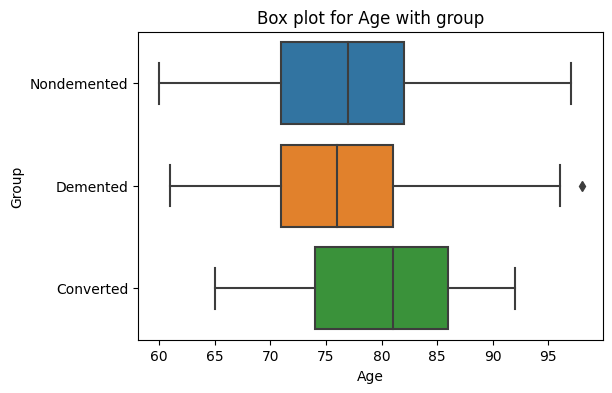

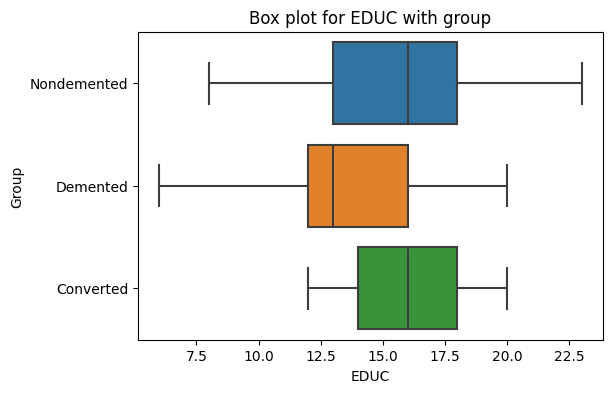

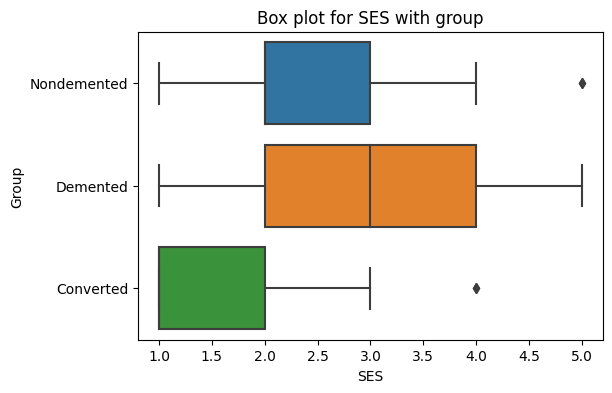

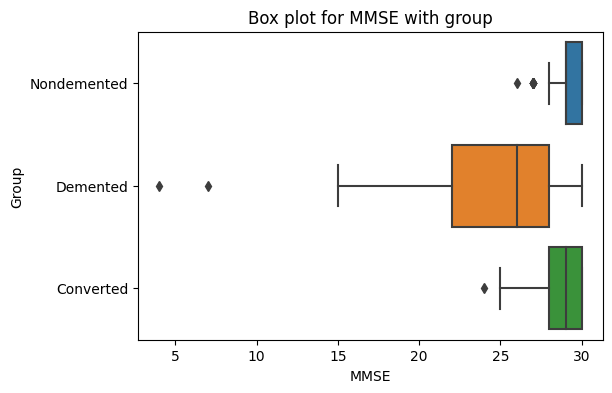

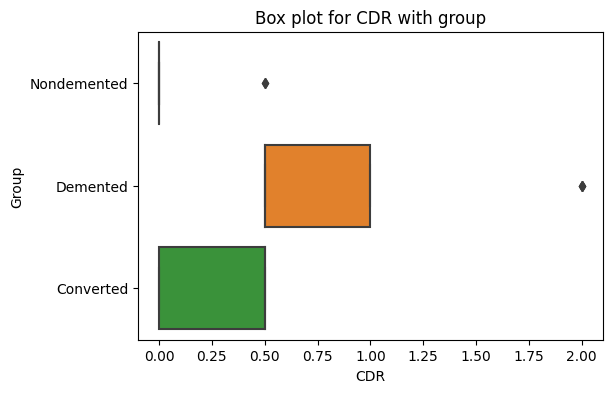

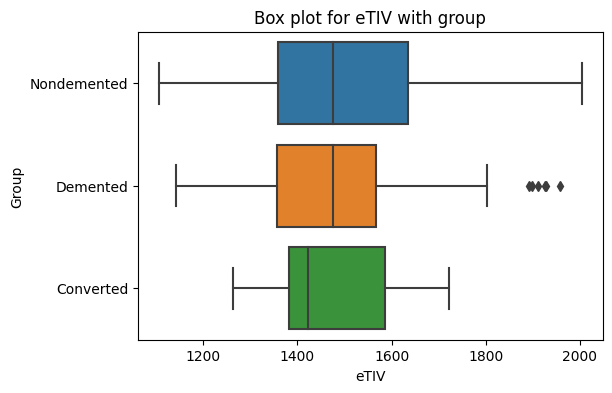

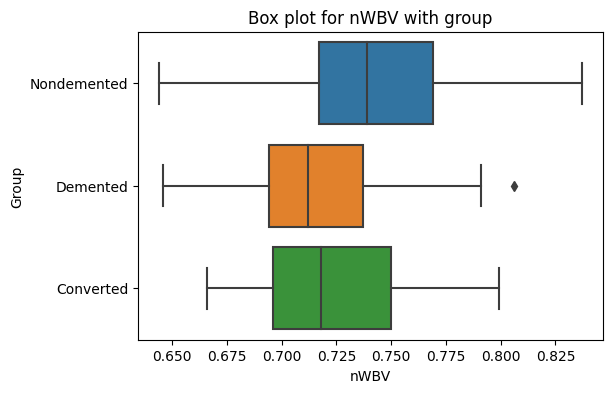

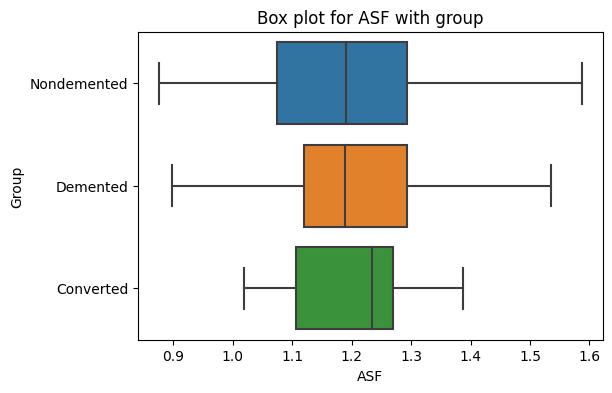

In [183]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=col,y="Group",data= df)
    plt.title(f"Box plot for {col} with group")

In [184]:
#Removing CDR as it will have more high correlation with Group of Class
X=X.drop('CDR',axis=1)

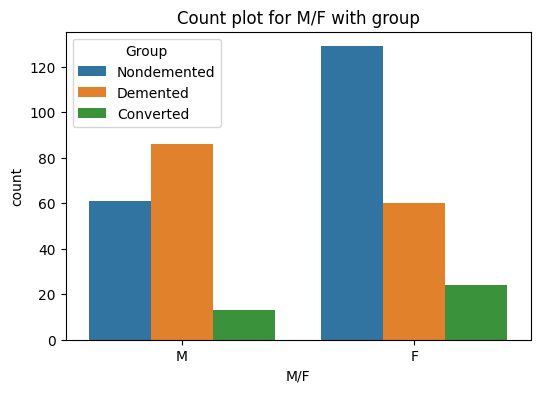

In [185]:
for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.countplot(x=col, hue='Group', data=df)
    plt.title(f"Count plot for {col} with group")

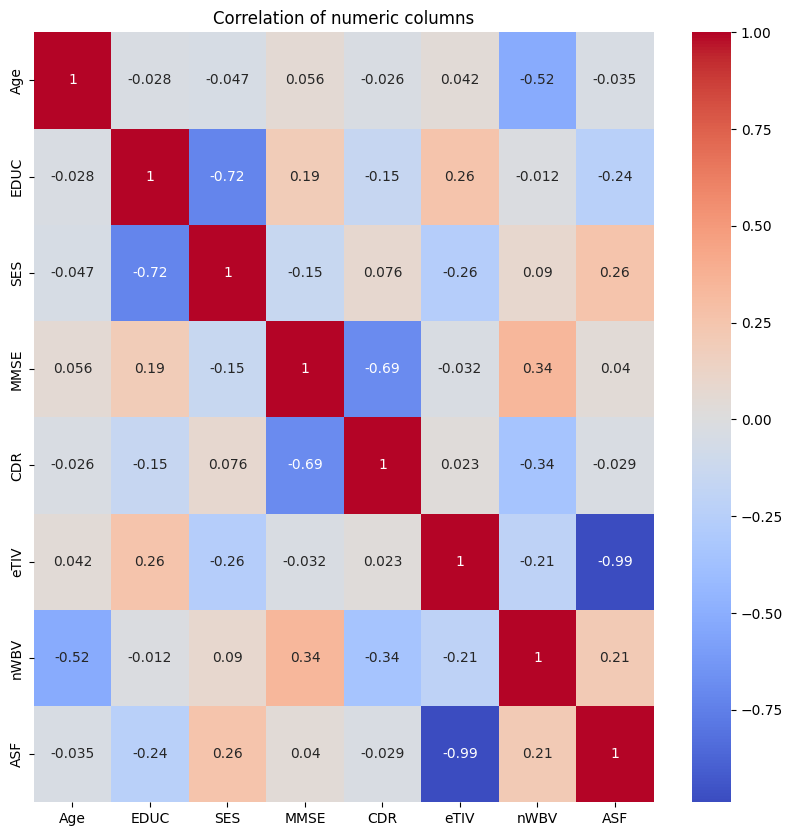

In [186]:
correlation_ =df[num_cols].corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_,annot=True,cmap='coolwarm')
plt.title('Correlation of numeric columns')
plt.show()

# Preprocesssing

In [187]:
print(f"Missing values in features are :\n{X.isna().sum()}")
print(f"\nMissing values in Labels are :{y.isna().sum()}")

Missing values in features are :
Visit        0
MR Delay     0
M/F          0
Age          0
EDUC         0
SES         19
MMSE         2
eTIV         0
nWBV         0
ASF          0
dtype: int64

Missing values in Labels are :0


In [188]:
num_preprocessor = Pipeline(steps=[('imputation', SimpleImputer(strategy='most_frequent')),
                                ('normalize', MinMaxScaler())])
label_encoder = LabelEncoder()

num_cols = X.select_dtypes(include=['float64','int64']).columns
cat_cols = X.select_dtypes(include=['object']).columns
print(X[cat_cols].shape)
print(X[num_cols].shape)
X[num_cols] = num_preprocessor.fit_transform(X[num_cols])

for col in cat_cols:
    X[col] = label_encoder.fit_transform(X[col])

y = label_encoder.fit_transform(y)

(373, 1)
(373, 9)


In [189]:
print(f"After Preprocessing,Missing values are : {X.isna().sum()}\n")
print(f"After Preprocessing :\n {X.head(10)}")

After Preprocessing,Missing values are : Visit       0
MR Delay    0
M/F         0
Age         0
EDUC        0
SES         0
MMSE        0
eTIV        0
nWBV        0
ASF         0
dtype: int64

After Preprocessing :
    Visit  MR Delay  M/F       Age      EDUC   SES      MMSE      eTIV  \
0   0.00  0.000000    1  0.710526  0.470588  0.25  0.884615  0.981069   
1   0.25  0.173172    1  0.736842  0.470588  0.25  1.000000  1.000000   
2   0.00  0.000000    1  0.394737  0.352941  0.25  0.730769  0.636971   
3   0.25  0.212202    1  0.421053  0.352941  0.25  0.923077  0.703786   
4   0.50  0.718075    1  0.526316  0.352941  0.25  0.692308  0.659243   
5   0.00  0.000000    0  0.736842  0.705882  0.50  0.923077  0.121381   
6   0.25  0.203865    0  0.789474  0.705882  0.50  0.884615  0.104677   
7   0.00  0.000000    1  0.526316  0.352941  0.75  0.923077  0.649220   
8   0.25  0.382721    1  0.605263  0.352941  0.75  0.961538  0.662584   
9   0.50  0.607427    1  0.657895  0.352941  0.75  1

## Spliting of Data into Training and Testing Datasets

In [191]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=19,stratify=y)
print(f"Shape of Training Dataset is: {X_train.shape}")
print(f"Shape of Training Dataset is: {X_test.shape}")

Shape of Training Dataset is: (298, 10)
Shape of Training Dataset is: (75, 10)


# Model Selection